In [2]:
#save model to collab
#from google.colab import drive
#drive.mount('/content/drive')


## Data Loading

In [3]:
import pandas as pd
import numpy as np

#aito_comments = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Capstone/Data/annotated_aito_comment.xlsx', usecols=lambda x: x != 'Unnamed: 0')
aito_comments = pd.read_excel('Data/annotated_aito_comment.xlsx', usecols=lambda x: x != 'Unnamed: 0')

#li_comments = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Capstone/Data/annotated_li_comment.xlsx', usecols=lambda x: x != 'Unnamed: 0')
li_comments = pd.read_excel('Data/annotated_li_comment.xlsx', usecols=lambda x: x != 'Unnamed: 0')
#aito_video = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Capstone/Data/Aito_Video.xlsx', usecols=lambda x: x != 'Unnamed: 0')
aito_video = pd.read_excel('Data/Aito_Video.xlsx', usecols=lambda x: x != 'Unnamed: 0')
#li_video = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Capstone/Data/Li_Video.xlsx', usecols=lambda x: x != 'Unnamed: 0')
li_video = pd.read_excel('Data/Li_Video.xlsx', usecols=lambda x: x != 'Unnamed: 0')


col_names_comment = ["key","video_link","cid","comment_time","likes","replies","comment_IP","comment","sentiment"]
col_names_video=["video_id","video_description","video_topic","video_length","video_link","release_date","release_account","likes","num_comments","archives","shares","sentiment"]
li_comments.columns = col_names_comment
aito_comments.columns = col_names_comment
li_video.columns = col_names_video
aito_video.columns = col_names_video

# get rid of irrelavant
irrelavant_links= [
    "https://www.douyin.com/video/6953924024518839593",
    "https://www.douyin.com/video/6979613318105353479",
    "https://www.douyin.com/video/6724238509927976206",
    "https://www.douyin.com/video/7127604715617127684",
    "https://www.douyin.com/video/7096756034928119081",
    "https://www.douyin.com/video/7027705719998713129",
    "https://www.douyin.com/video/7092745278658268454",
    "https://www.douyin.com/video/6804754290553457933",
    "https://www.douyin.com/video/7093853232191048997",
    "https://www.douyin.com/video/7104836122911591710",
    "https://www.douyin.com/video/6864048392897694983"
]

li_video = li_video[~li_video["video_link"].isin(irrelavant_links)]
links = li_video["video_link"].unique()
li_comments = li_comments[li_comments["video_link"].isin(links)]



# Filter and rename the column in the second DataFrame before merging
aito_video_merge = aito_video[['video_link', 'sentiment']].rename(columns={'sentiment': 'video_sentiment'})
# Merge the dataframes on 'video_link'
aito_comments = pd.merge(aito_comments, aito_video_merge, on='video_link', how='inner')
# Filter and rename the column in the second DataFrame before merging
li_video_merge = li_video[['video_link', 'sentiment']].rename(columns={'sentiment': 'video_sentiment'})
# Merge the dataframes on 'video_link'
li_comments = pd.merge(li_comments, li_video_merge, on='video_link', how='inner')




li_comments['time_of_comment'] = li_comments['comment_time']
aito_comments['time_of_comment'] = aito_comments['comment_time']
if not isinstance(li_comments.index, pd.DatetimeIndex): 
    #li_comments['comment_time'] = pd.to_datetime(li_comments['comment_time'])
    #li_comments['time_of_comment'] = li_comments['comment_time']
    li_comments.set_index('comment_time', inplace=True)
if not isinstance(aito_comments.index, pd.DatetimeIndex): 
    #aito_comments['comment_time'] = pd.to_datetime(li_comments['comment_time'])
    #aito_comments['time_of_comment'] = aito_comments['comment_time']
    aito_comments.set_index('comment_time', inplace=True)

# Comment Distibution

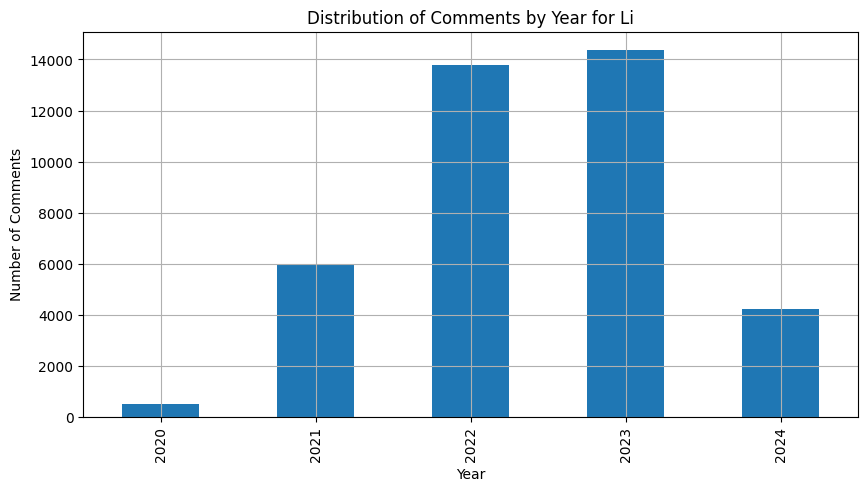

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


# Extract hour from the timestamp
li_comments['Year'] = li_comments.index.year

# Plotting the distribution of hours
plt.figure(figsize=(10, 5))
li_comments['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Comments by Year for Li')
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.show()


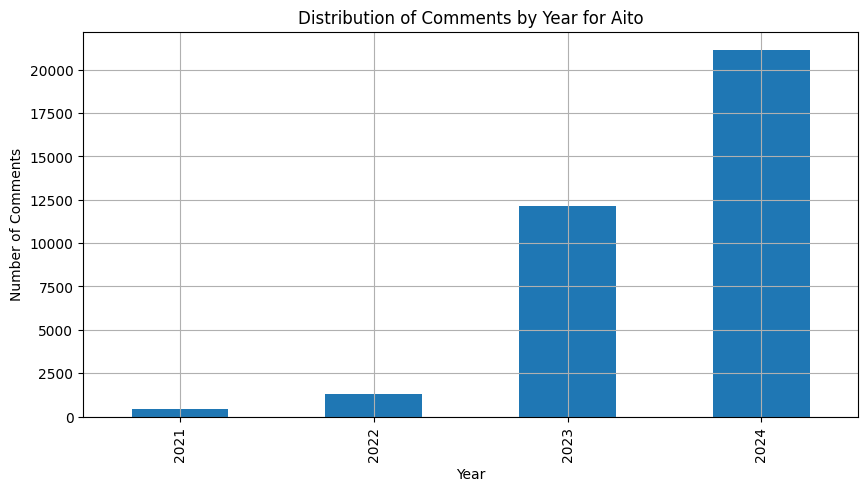

In [5]:
aito_comments['Year'] = aito_comments.index.year

# Plotting the distribution of hours
plt.figure(figsize=(10, 5))
aito_comments['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Comments by Year for Aito')
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.show()

# Map negative/ neutral / positive to numberical varible

In [6]:
li_comments['sentiment'] = li_comments['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
aito_comments['sentiment'] = aito_comments['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
li_comments = li_comments.dropna()
aito_comments = aito_comments.dropna()

# Calculate users' sentiment towards brands

Sentiment Towards' Definition:

For simplification: 

Sentiment Towards Brand = Sentence Sentiment (-1, 0, 1) * Video Sentiment (-1,1)

In [7]:
li_comments['sentiment_towards_brand'] = li_comments['sentiment']*li_comments['video_sentiment']
aito_comments['sentiment_towards_brand'] = aito_comments['sentiment']*aito_comments['video_sentiment']

In [8]:
li_comments['sentiment'].describe()

count    38805.000000
mean        -0.282824
std          0.764190
min         -1.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: sentiment, dtype: float64

# Li's overall sentiment

In [9]:
mean_value = li_comments['sentiment_towards_brand'].mean()
mean_value

-0.2045870377528669

# Aito's overall sentiment 

In [10]:
mean_value = aito_comments['sentiment_towards_brand'].mean()
mean_value

-0.11655313155701187

# Li vs Aito 14-Days Rolling Average

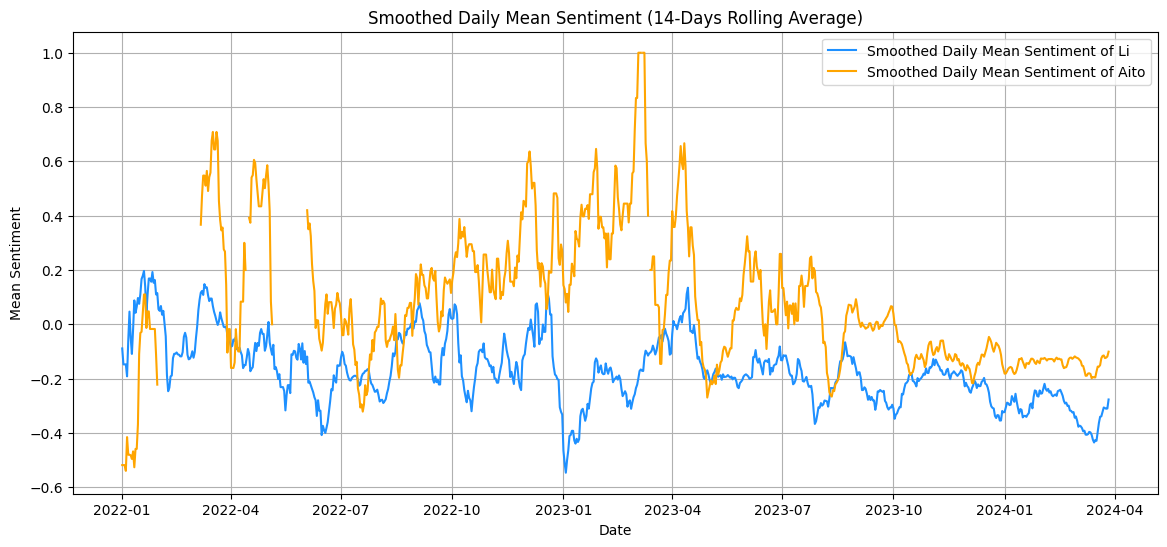

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

cutoff_date = pd.Timestamp('2022-01')

# Filter the dataframes
li_comments_7 = li_comments[li_comments.index >= cutoff_date]
aito_comments_7 = aito_comments[aito_comments.index >= cutoff_date]
# Resample the sentiment data
daily_mean_sentiment_li = li_comments_7['sentiment_towards_brand'].resample('D').mean()


# Applying a 7-day rolling average to smooth the data
smoothed_daily_mean_sentiment_li = daily_mean_sentiment_li.rolling(window=14, min_periods=5,center=True).mean()
daily_mean_sentiment_aito = aito_comments_7['sentiment_towards_brand'].resample('D').mean()
smoothed_daily_mean_sentiment_aito = daily_mean_sentiment_aito.rolling(window=14,min_periods=5, center=True).mean()

# Plotting the smoothed daily sentiment
plt.figure(figsize=(14, 6))
plt.plot(smoothed_daily_mean_sentiment_li, label='Smoothed Daily Mean Sentiment of Li', color='dodgerblue')
plt.plot(smoothed_daily_mean_sentiment_aito, label='Smoothed Daily Mean Sentiment of Aito', color='orange')
plt.title('Smoothed Daily Mean Sentiment (14-Days Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
#plt.savefig('Plots/Smoothed Daily Mean Sentiment(14DaysRolling).png')
plt.show()


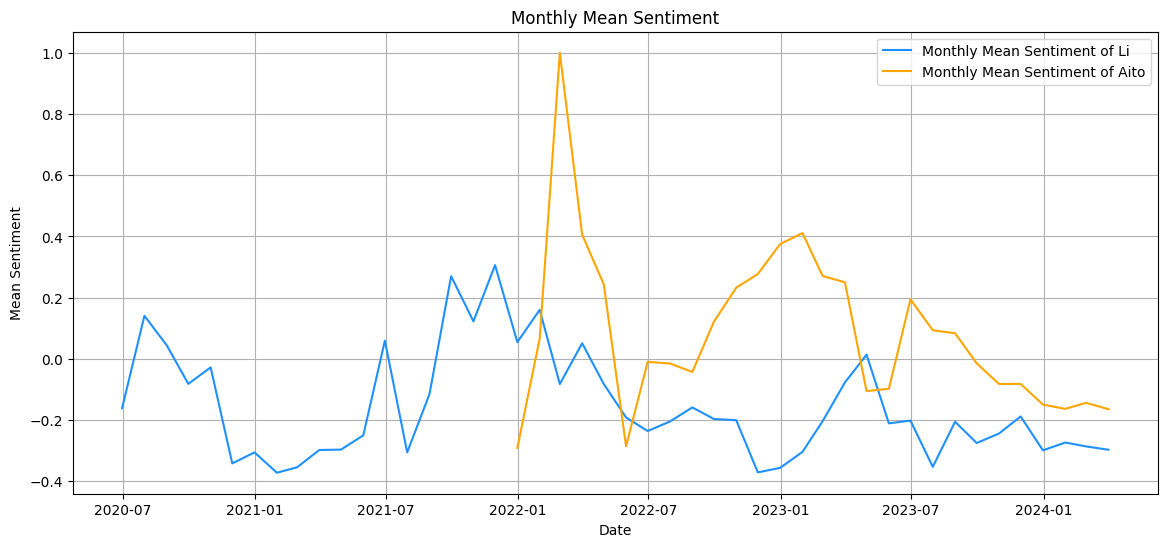

In [12]:
monthly_sentiment_li = li_comments['sentiment_towards_brand'].resample('M').mean()
monthly_sentiment_aito = aito_comments['sentiment_towards_brand'].resample('M').mean()
# Plotting the smoothed daily sentiment
plt.figure(figsize=(14, 6))
plt.plot(monthly_sentiment_li, label='Monthly Mean Sentiment of Li', color='dodgerblue')
plt.plot(monthly_sentiment_aito, label='Monthly Mean Sentiment of Aito', color='orange')
plt.title('Monthly Mean Sentiment')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.show()



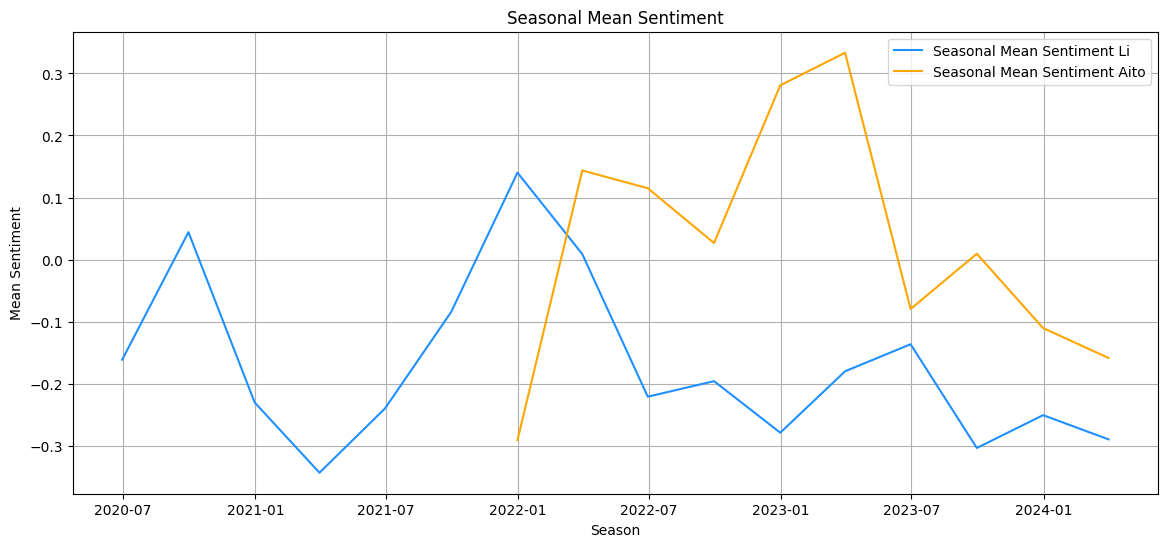

In [13]:
seasonal_sentiment_li = li_comments['sentiment_towards_brand'].resample('Q').mean()
seasonal_sentiment_aito = aito_comments['sentiment_towards_brand'].resample('Q').mean()
# Plotting the smoothed daily sentiment
plt.figure(figsize=(14, 6))

plt.plot(seasonal_sentiment_li, label='Seasonal Mean Sentiment Li', color='dodgerblue')
plt.plot(seasonal_sentiment_aito, label='Seasonal Mean Sentiment Aito', color='orange')

plt.title('Seasonal Mean Sentiment')
plt.xlabel('Season')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.show()


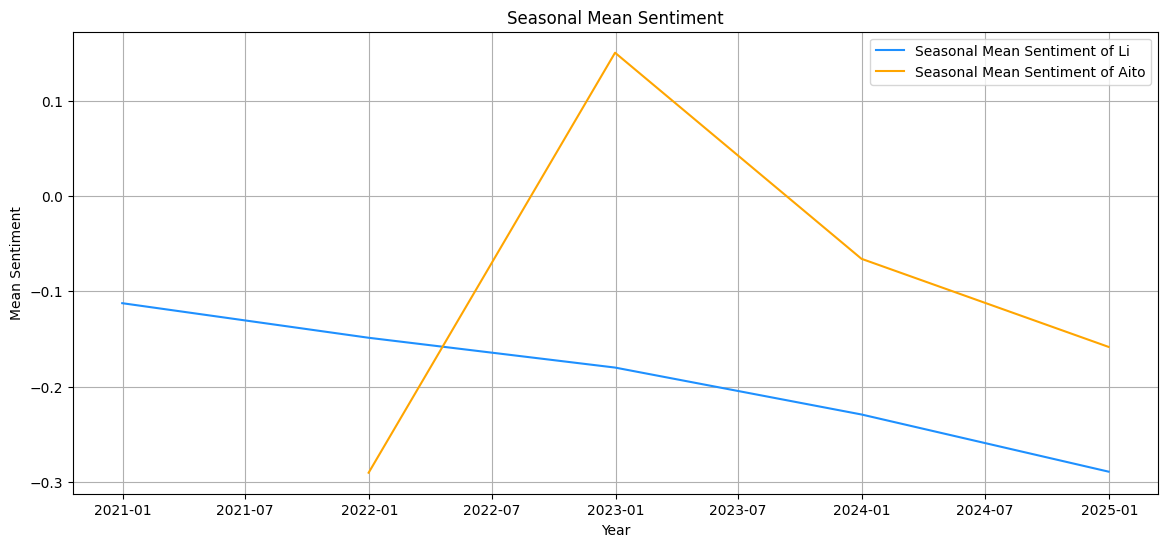

In [14]:
yearly_sentiment_li = li_comments['sentiment_towards_brand'].resample('A').mean()
yearly_sentiment_aito = aito_comments['sentiment_towards_brand'].resample('A').mean()
plt.figure(figsize=(14, 6))
plt.plot(yearly_sentiment_li, label='Seasonal Mean Sentiment of Li', color='dodgerblue')
plt.plot(yearly_sentiment_aito, label='Seasonal Mean Sentiment of Aito', color='orange')
plt.title('Seasonal Mean Sentiment')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.show()

# Sentiment Score Decayed by days

Include each comment to calculate the sentiment score might not be reasonable. For those previous comments, they should not contributed as much as the most current to the total public perception. It is obvious that the current comments should contribute more than the previous comments.

## Calculate days since the last comment(In the dataset, the last comment is colleted at "2024-03-28")

In [15]:
reference_date = pd.Timestamp('2024-03-28')

# Calculate the days difference and create a new column
li_comments['days_since_last'] = (reference_date - li_comments['time_of_comment']).dt.days.astype(int)

aito_comments['days_since_last'] = (reference_date - aito_comments['time_of_comment']).dt.days.astype(int)

Text(0, 0.5, 'Number of Comments')

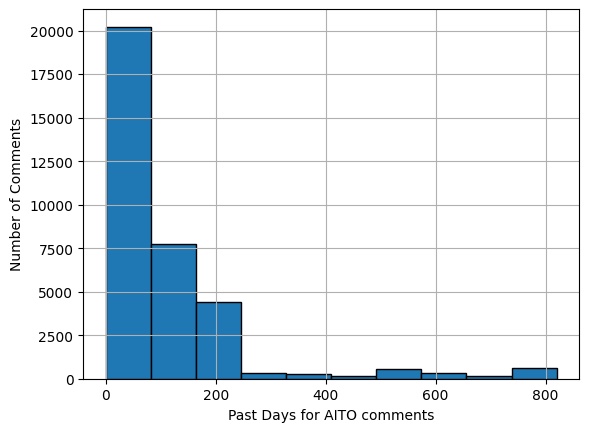

In [16]:
aito_comments['days_since_last'].hist( edgecolor='black')


# Adding axis labels
plt.xlabel('Past Days for AITO comments')
plt.ylabel('Number of Comments')

 There is heavy concentration of comments in the first bin, suggesting a high volume of comments in the most recent time period for Aito.

Text(0, 0.5, 'Number of Comments')

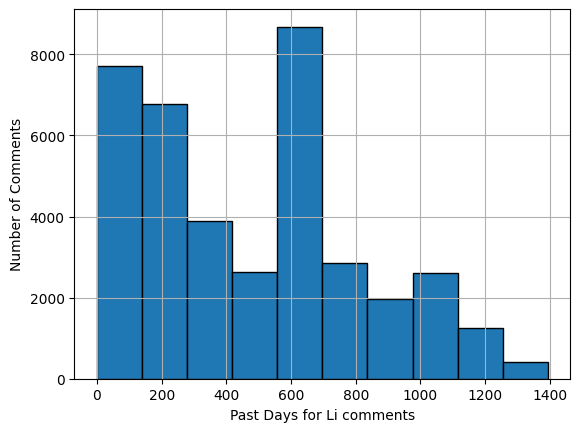

In [17]:
li_comments['days_since_last'].hist( edgecolor='black')


# Adding axis labels
plt.xlabel('Past Days for Li comments')
plt.ylabel('Number of Comments')

Li has a more uniform distribution of comments over time, although there are still peaks and troughs. 

## Exponential decay on Sentiment

### Set a date and only get the data after that

In [18]:

start_date = pd.Timestamp('2020-02-01')


li_comments = li_comments[li_comments.index > start_date]
aito_comments = aito_comments[aito_comments.index > start_date]

In [19]:
lambda_value = 0.9  # Exponential decay factor

# Rescore the score, give the new data more score compared to the old score
li_comments['decayed_weights'] = np.power(0.9, li_comments['days_since_last'] / 30)
score = li_comments['sentiment_towards_brand'] *li_comments['decayed_weights']
mean_value = score.mean()
mean_value

-0.07942598125722578

In [20]:
lambda_value = 0.9  # Exponential decay factor

# Rescore the score, give the new data more score compared to the old score
aito_comments['decayed_weights'] = np.power(0.9, aito_comments['days_since_last']/ 30)
score = aito_comments['sentiment_towards_brand'] *aito_comments['decayed_weights']
mean_value = score.mean()
mean_value

-0.10169953290325398

In [22]:
days_array_li = li_comments['days_since_last'].unique()
decay_frac_li = np.power(0.9, days_array_li / 30)
decay_frac_li.sort()
days_array_li.sort()
days_array_li = days_array_li[::-1]
frac_dict_li = dict(zip(days_array_li, decay_frac_li))

In [24]:
sample_df_li = pd.DataFrame()
for day, frac in frac_dict_li.items():
    # get sample
    group = li_comments[li_comments['days_since_last'] == day]
    # calculate sample
    sample_n = int(np.ceil(len(group) * frac))
    
    # if there is very less sample to sample , just take 1
    if sample_n < 1:
        sample_n = 1
    
    # Sample and add to sampled_df
    sample_df_li = pd.concat([sample_df_li, group.sample(n=sample_n, random_state=1)])

# sample df
sample_df_li

,key,video_link,cid,likes,replies,comment_IP,comment,sentiment,video_sentiment,time_of_comment,Year,sentiment_towards_brand,days_since_last,decayed_weights
comment_time,,,,,,,,,,,,,,
2020-06-02 20:12:54,1074,https://www.douyin.com/video/6833702112795364612,6833722341064399872,2,0,无,最喜欢的车评人，没有之一！,1.0,1,2020-06-02 20:12:54,2020,1.0,1394,0.007478
2020-06-03 00:36:37,976,https://www.douyin.com/video/6833702112795364612,6833790280853199872,9,1,无,途昂安全比不过理想\n汉兰达配置比不过理想\nct6油耗比不过理想\n帕杰罗外观比不过理想\...,1.0,1,2020-06-03 00:36:37,2020,1.0,1393,0.007505
2020-06-04 14:05:24,525,https://www.douyin.com/video/6833702112795364612,6834369814702940160,1173,14,无,你太狠了,-1.0,1,2020-06-04 14:05:24,2020,-1.0,1392,0.007531
2020-06-05 13:30:57,1023,https://www.douyin.com/video/6833702112795364612,6834732025635930112,2,0,无,这么说不公平的，你用所有车最强的一点挨个和它比这种比较没意义。,-1.0,1,2020-06-05 13:30:57,2020,-1.0,1391,0.007557
2020-06-06 08:56:57,994,https://www.douyin.com/video/6833702112795364612,6835032478659959808,2,0,无,你刚刚说的那些车都是某一项很突出，但是他们的其他项呢？有没有全能项的车呢？,0.0,1,2020-06-06 08:56:57,2020,0.0,1390,0.007584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 19:36:41,41977,https://www.douyin.com/video/7349840892657732874,7350634644864789504,1,0,广东,升级了价钱也涨了,-1.0,1,2024-03-26 19:36:41,2024,-1.0,1,0.996494
2024-03-26 20:23:58,41749,https://www.douyin.com/video/7344258514434411830,7350646833092780032,0,0,福建,棺材,-1.0,1,2024-03-26 20:23:58,2024,-1.0,1,0.996494
2024-03-27 02:44:10,23275,https://www.douyin.com/video/7112999136605031694,7350744740842909696,0,0,广东,这种人也有媒体采访,-1.0,1,2024-03-27 02:44:10,2024,-1.0,0,1.000000


In [25]:
sample_df_li['sentiment_towards_brand'].mean()


-0.24884338263177855

In [26]:
li_comments['sentiment_towards_brand'].mean()


-0.2045870377528669

In [27]:
days_array_aito = aito_comments['days_since_last'].unique()
decay_frac_aito = np.power(0.9, days_array_aito / 30)
decay_frac_aito.sort()
days_array_aito.sort()
days_array_aito = days_array_aito[::-1]
frac_dict_aito = dict(zip(days_array_aito, decay_frac_aito))

In [28]:
sample_df_aito = pd.DataFrame()
for day, frac in frac_dict_aito.items():
    # get sample
    group = aito_comments[aito_comments['days_since_last'] == day]
    # calculate sample
    sample_n = int(np.ceil(len(group) * frac))
    
    # if there is very less sample to sample , just take 1
    if sample_n < 1:
        sample_n = 1
    
    # sample and add result to sampled_df
    sample_df_aito = pd.concat([sample_df_aito, group.sample(n=sample_n, random_state=1)])

# print sample df
sample_df_aito

,key,video_link,cid,likes,replies,comment_IP,comment,sentiment,video_sentiment,time_of_comment,Year,sentiment_towards_brand,days_since_last,decayed_weights
comment_time,,,,,,,,,,,,,,
2021-12-28 23:48:20,543,https://www.douyin.com/video/7046657951309876494,7046780732148259840,1,0,无,华为出个4g卖这么贵，确实有问题,-1.0,1,2021-12-28 23:48:20,2021,-1.0,820,0.056143
2021-12-28 23:44:17,545,https://www.douyin.com/video/7046657951309876494,7046779684012779520,1,0,无,这样道歉，等于有又说了一次，,-1.0,1,2021-12-28 23:44:17,2021,-1.0,820,0.056143
2021-12-28 17:32:02,2,https://www.douyin.com/video/7046657951309876494,7046683775698560000,1493,251,无,华为以前是做通信的，人家做到了世界前列。然后华为做手机也做到了世界前列。我倒希望华为造车能做...,1.0,1,2021-12-28 17:32:02,2021,1.0,820,0.056143
2021-12-28 23:30:26,552,https://www.douyin.com/video/7046657951309876494,7046776121849180160,1,0,无,他这扇耳光，这下脸扇红都要被玩一个月,-1.0,1,2021-12-28 23:30:26,2021,-1.0,820,0.056143
2021-12-29 06:23:47,509,https://www.douyin.com/video/7046657951309876494,7046882626405810176,1,0,无,不黑华为，不买就行了,-1.0,1,2021-12-29 06:23:47,2021,-1.0,819,0.056340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27 00:23:45,33124,https://www.douyin.com/video/7349756324294462731,7350708619204079616,0,0,广东,雷总知道都是这帮人是自己的粉丝，心里怎么想,0.0,1,2024-03-27 00:23:45,2024,0.0,0,1.000000
2024-03-27 00:15:35,32338,https://www.douyin.com/video/7349753841769827634,7350706513973059584,0,0,四川,问界M9真的是太爽了,1.0,1,2024-03-27 00:15:35,2024,1.0,0,1.000000
2024-03-27 00:09:01,33649,https://www.douyin.com/video/7349801493085703475,7350704819713110016,0,0,海南,还有用华为手机的女生一样，让人很难不多看一眼,1.0,1,2024-03-27 00:09:01,2024,1.0,0,1.000000


In [29]:
sample_df_aito['sentiment_towards_brand'].mean()

-0.1345475028163725

In [30]:
aito_comments['sentiment_towards_brand'].mean()

-0.11655313155701187

# Change the location name to match the Pyechart's location name 

In [31]:
full_name = {
    "上海": "上海市",
    "中国台湾": "台湾省",
    "中国澳门": "澳门特别行政区",
    "中国香港": "香港特别行政区",
    "云南": "云南省",
    "内蒙古": "内蒙古自治区",
    "北京": "北京市",
    "吉林": "吉林省",
    "四川": "四川省",
    "天津": "天津市",
    "宁夏": "宁夏回族自治区",
    "安徽": "安徽省",
    "山东": "山东省",
    "山西": "山西省",
    "广东": "广东省",
    "广西": "广西壮族自治区",
    "新疆": "新疆维吾尔自治区",
    "江苏": "江苏省",
    "江西": "江西省",
    "河北": "河北省",
    "河南": "河南省",
    "浙江": "浙江省",
    "海南": "海南省",
    "湖北": "湖北省",
    "湖南": "湖南省",
    "甘肃": "甘肃省",
    "福建": "福建省",
    "西藏": "西藏自治区",
    "贵州": "贵州省",
    "辽宁": "辽宁省",
    "重庆": "重庆市",
    "陕西": "陕西省",
    "青海": "青海省",
    "黑龙江": "黑龙江省"
}
aito_comments['comment_IP']=aito_comments['comment_IP'].map(full_name)
li_comments['comment_IP']=li_comments['comment_IP'].map(full_name)
sample_df_aito['comment_IP']=sample_df_aito['comment_IP'].map(full_name)
sample_df_li['comment_IP']=sample_df_li['comment_IP'].map(full_name)

In [32]:
Aito_map = sample_df_aito.groupby('comment_IP')['sentiment_towards_brand'].mean()
Li_map = sample_df_li.groupby('comment_IP')['sentiment_towards_brand'].mean()

In [33]:
# Get the keys (index) as a list
keys_Aito = Aito_map.index.tolist()

# Get the values as a list
values_Aito = Aito_map.values.tolist()

In [34]:
# Get the keys (index) as a list
keys_Li = Aito_map.index.tolist()

# Get the values as a list
values_Li = Aito_map.values.tolist()

In [35]:
#!pip install pyecharts

In [36]:
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.faker import Faker

# create map
map_chart = Map()

# add value
map_chart.add("Average Sentiment Of AITO in 2024 March ", [list(z) for z in zip(keys_Li, values_Li)], "china")

# Define the color gradient
map_chart.set_global_opts(
    title_opts=opts.TitleOpts(title="China Map"),
    visualmap_opts=opts.VisualMapOpts(
        is_calculable=True,
        precision =True,
        dimension=0,
        pos_top='middle',
        range_text=['Low', 'High'],  # Text for the start and end of the range
        range_color=['#D50000', '#FFEBEE'],  # Colors to use for the gradient from low to high
        min_=-0.3,  # Minimum value of the range
        max_=0,
        is_inverse=True, # Maximum value of the range
        item_width = 0,
        item_height = 0
      
    )
)

map_chart.render_notebook()
# save map to file
#map_chart.render("china_map_aito.html")
